In [110]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from io import StringIO

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [112]:
def get_team_codes():
    """Returns a list of all current NBA team codes"""
    return [
        'ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
        'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
        'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
    ]

In [113]:
def get_number_stats_categories():
    '''Retunrs a list of all the statistics in the advanced game log on
    Basketball Reference that are numberic (eg PtsFwd as opposed to Opponent)'''
    return [
        'PtsFwd', 'PtsAgt', 'ORtg','DRtg', 'Pace', 'FTr', '3PAr',
        'TS%','TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
        'ORB%', 'FT/FGA', 'OppeFG%', 'OppTOV%', 'DRB%', 'OppFT/FGA'
       ]

In [114]:
def scrape_team_advanced_gamelog(team_code, year=2024):
    """
    Scrapes advanced game log for a specific team and year.
    
    Args:
        team_code (str): Team code (e.g., 'CHO' for Charlotte).
        year (int): Season year (e.g., 2024 for the 2023-24 season).
    
    Returns:
        pandas.DataFrame: Cleaned advanced game log data, or None if scraping fails.
    """
    url = f"https://www.basketball-reference.com/teams/{team_code}/{year}/gamelog-advanced/"
    
    # Add a polite delay to avoid overloading the server
    time.sleep(5)
    
    try:
        # Fetch the page
        response = requests.get(url)
        response.raise_for_status()
        
        # Check if the page contains valid data
        if "Page Not Found" in response.text:
            print(f"Warning: No data found for {team_code} {year}")
            return None
        
        # Parse the HTML and extract the advanced game log table
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table', id='tgl_advanced')
        
        if table is None:
            print(f"Warning: No table found for {team_code} {year}")
            return None
        
        # Convert the HTML table to a DataFrame
        df = pd.read_html(StringIO(str(table)))[0]
        
        return df
    
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred for {team_code}: {http_err}")
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred for {team_code}: {conn_err}")
    except Exception as err:
        print(f"An error occurred for {team_code}: {err}")
    
        return None


In [115]:
# Scrape regular season stats
cho_2024 = scrape_team_advanced_gamelog('MIA')

# Set column names to the stats they represent
cho_2024.columns = cho_2024.columns.get_level_values(1)

# Make Game Number (G) the index
cho_2024.set_index('G', inplace=True)

# Drop unneccessary columns
cho_2024.drop(columns=['Rk'], inplace=True)
cho_2024.drop(columns=['Unnamed: 18_level_1'], inplace=True)
cho_2024.drop(columns=['Unnamed: 23_level_1'], inplace=True)


# Rename columns
cho_2024.rename(columns={'Unnamed: 3_level_1': 'Home/Away'}, inplace=True)
cho_2024.rename(columns={'Tm': 'PtsFwd'}, inplace=True)
cho_2024.rename(columns={'Opp': 'PtsAgt'}, inplace=True)
cho_2024.columns.values[2] = 'Opponent'        # Column indexed at 2 and 5 both titled 'Opp' originally
cho_2024.columns.values[20] = 'OppeFG%'
cho_2024.columns.values[21] = 'OppTOV%'
cho_2024.columns.values[23] = 'OppFT/FGA'

# Drop extraneous rows that do not house game info
cho_2024 = cho_2024[cho_2024.index.notnull()]  # Keep only non-NaN indices (ie rows without the 3 collective headers)
cho_2024 = cho_2024[cho_2024.index != "G"]     # Keep only rows wiht games (ie rows without individual stat headers)

# Edit values in Home/Away column to be 1 and 0
cho_2024['Home/Away'] = cho_2024['Home/Away'].fillna('1')
cho_2024['Home/Away'] = cho_2024['Home/Away'].replace('@', '0')

# Edit values in W/L to be 1/0
cho_2024['W/L'] = cho_2024['W/L'].replace('W', '1')
cho_2024['W/L'] = cho_2024['W/L'].replace('L', '0')

In [116]:
cho_2024

,Date,Home/Away,Opponent,W/L,PtsFwd,PtsAgt,ORtg,DRtg,Pace,FTr,...,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA,OppeFG%,OppTOV%,DRB%,OppFT/FGA
G,,,,,,,,,,,,,,,,,,,,,
1,2023-10-25,1,DET,1,103,102,109.4,108.3,94.2,.283,...,11.7,5.0,.446,6.3,29.1,.228,.505,14.7,65.3,.098
2,2023-10-27,0,BOS,0,111,119,111.7,119.8,99.3,.258,...,8.1,10.7,.517,10.8,22.0,.213,.558,12.7,68.0,.137
3,2023-10-28,0,MIN,0,90,106,92.4,108.9,97.4,.161,...,6.2,1.9,.471,13.9,18.4,.092,.581,15.2,82.5,.070
4,2023-10-30,0,MIL,0,114,122,111.3,119.1,102.5,.233,...,6.8,4.0,.552,13.7,17.1,.221,.575,13.0,78.6,.253
5,2023-11-01,1,BRK,0,105,109,101.7,105.5,103.3,.198,...,9.7,10.9,.500,15.4,21.6,.154,.549,16.2,83.3,.232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2024-04-07,0,IND,0,115,117,120.6,122.7,95.3,.381,...,3.1,3.7,.512,6.7,19.5,.345,.564,6.8,88.6,.233
79,2024-04-09,0,ATL,1,117,111,105.2,99.8,92.0,.239,...,7.2,4.5,.580,15.6,10.6,.170,.442,11.8,70.7,.097
80,2024-04-10,1,DAL,0,92,111,102.2,123.3,90.0,.160,...,3.3,2.3,.488,17.2,27.9,.160,.580,7.0,81.0,.115


In [117]:
# Take the stats and make them rolling averages (currently past 5 games but may be interesting to optimize)
number_stats = get_number_stats_categories()
rolling_avgs = cho_2024.copy()

# For every stat that is a number, get the rolling average and drop the non-rolling avg column of that same stat
for stat in number_stats:
    rolling_avgs[f'Avg_{stat}'] = rolling_avgs[stat].shift().rolling(5).mean()
    rolling_avgs = rolling_avgs.drop(columns=stat)

# Drop the first five rows becasue they are all NaN
rolling_avgs = rolling_avgs.drop(index=rolling_avgs.index[:5])

rolling_avgs

,Date,Home/Away,Opponent,W/L,Avg_PtsFwd,Avg_PtsAgt,Avg_ORtg,Avg_DRtg,Avg_Pace,Avg_FTr,...,Avg_STL%,Avg_BLK%,Avg_eFG%,Avg_TOV%,Avg_ORB%,Avg_FT/FGA,Avg_OppeFG%,Avg_OppTOV%,Avg_DRB%,Avg_OppFT/FGA
G,,,,,,,,,,,,,,,,,,,,,
6,2023-11-03,1,WAS,1,104.6,111.6,105.30,112.32,99.34,0.2266,...,8.50,6.50,0.4972,12.02,21.64,0.1816,0.5536,14.36,75.54,0.1580
7,2023-11-06,1,LAL,1,108.2,114.0,107.30,113.16,100.78,0.2050,...,7.94,5.88,0.5442,14.68,20.06,0.1660,0.5822,15.10,80.12,0.1606
8,2023-11-08,0,MEM,1,107.6,111.6,106.76,110.80,100.74,0.1898,...,8.54,5.20,0.5476,15.70,20.66,0.1552,0.5892,15.82,83.88,0.1604
9,2023-11-11,0,ATL,1,111.2,110.8,110.30,109.82,100.88,0.2408,...,9.14,7.84,0.5586,16.38,22.28,0.2070,0.5630,15.18,81.96,0.1930
10,2023-11-12,0,SAS,1,111.8,108.2,111.40,107.76,100.42,0.2538,...,9.78,9.00,0.5602,16.36,22.36,0.2176,0.5560,16.34,79.86,0.1768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2024-04-07,0,IND,0,118.8,100.2,121.14,102.62,97.94,0.2488,...,9.86,9.78,0.5866,12.38,21.10,0.2142,0.4972,13.46,80.66,0.1656
79,2024-04-09,0,ATL,1,113.4,107.2,117.66,111.22,96.42,0.2858,...,7.18,9.12,0.5488,12.06,21.92,0.2550,0.5238,10.68,82.54,0.1962
80,2024-04-10,1,DAL,0,113.0,108.0,115.40,110.22,94.40,0.2620,...,6.46,6.82,0.5488,12.58,21.12,0.2272,0.5088,10.22,79.94,0.1792


In [118]:
rolling_avgs = rolling_avgs.drop(columns='Opponent')
rolling_avgs = rolling_avgs.drop(columns='Date')


numeric_features = rolling_avgs.select_dtypes(include=['float64', 'int64']).columns
print(numeric_features)
scaler = StandardScaler()
rolling_avgs[numeric_features] = scaler.fit_transform(rolling_avgs[numeric_features])

rolling_avgs

Index(['Avg_PtsFwd', 'Avg_PtsAgt', 'Avg_ORtg', 'Avg_DRtg', 'Avg_Pace',
       'Avg_FTr', 'Avg_3PAr', 'Avg_TS%', 'Avg_TRB%', 'Avg_AST%', 'Avg_STL%',
       'Avg_BLK%', 'Avg_eFG%', 'Avg_TOV%', 'Avg_ORB%', 'Avg_FT/FGA',
       'Avg_OppeFG%', 'Avg_OppTOV%', 'Avg_DRB%', 'Avg_OppFT/FGA'],
      dtype='object')


,Home/Away,W/L,Avg_PtsFwd,Avg_PtsAgt,Avg_ORtg,Avg_DRtg,Avg_Pace,Avg_FTr,Avg_3PAr,Avg_TS%,...,Avg_STL%,Avg_BLK%,Avg_eFG%,Avg_TOV%,Avg_ORB%,Avg_FT/FGA,Avg_OppeFG%,Avg_OppTOV%,Avg_DRB%,Avg_OppFT/FGA
G,,,,,,,,,,,,,,,,,,,,,
6,1,1,-0.978298,0.501900,-1.736071,-0.034694,1.355918,-0.785975,-0.744849,-1.590177,...,0.541163,-0.239292,-1.553745,0.214024,0.007656,-0.865561,0.266921,0.944611,-0.886270,-0.742430
7,1,1,-0.343206,0.880785,-1.343225,0.105208,1.978513,-1.278861,-0.086608,-0.107773,...,0.147524,-0.608278,0.204542,1.779607,-0.823928,-1.287797,1.238515,1.350278,0.447257,-0.640681
8,0,1,-0.449055,0.501900,-1.449294,-0.287850,1.961219,-1.625707,0.239188,-0.049640,...,0.569280,-1.012973,0.331738,2.379944,-0.508137,-1.580114,1.476318,1.744981,1.542030,-0.648508
9,0,1,0.186037,0.375605,-0.753957,-0.451069,2.021749,-0.461947,-0.246182,0.749696,...,0.991037,0.558194,0.743252,2.780168,0.344500,-0.178076,0.586256,1.394134,0.982997,0.627264
10,0,1,0.291886,-0.034854,-0.537892,-0.794161,1.822865,-0.165303,0.132805,0.858696,...,1.440911,1.248555,0.803109,2.768397,0.386605,0.108828,0.348454,2.030044,0.371554,-0.006709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0,0,1.526786,-1.297805,1.375265,-1.650228,0.750618,-0.279397,1.801678,1.708898,...,1.497145,1.712763,1.790743,0.425907,-0.276557,0.016802,-1.649089,0.451232,0.604485,-0.445011
79,0,1,0.574149,-0.192723,0.691714,-0.217899,0.093434,0.564899,1.116842,0.800562,...,-0.386702,1.319972,0.376630,0.237566,0.155025,1.121110,-0.745439,-1.072761,1.151871,0.752493
80,1,0,0.503583,-0.066428,0.247799,-0.384449,-0.779928,0.021811,1.562318,0.560762,...,-0.892810,-0.048848,0.376630,0.543620,-0.266030,0.368665,-1.255016,-1.324933,0.394847,0.087213


In [119]:
X = rolling_avgs.drop(columns=['W/L'])
y = rolling_avgs['W/L']

# Use 20% of the data for testing, 80% for training
test_size = int(X.shape[0] * 0.2)

# Split data into train and test
X_train = X[:-test_size]
X_test = X[-test_size:]

# Split outcomes (W/L) into train and test
y_train = y[:-test_size]
y_test = y[-test_size:]


In [120]:

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.67      0.67      0.67         9

    accuracy                           0.60        15
   macro avg       0.58      0.58      0.58        15
weighted avg       0.60      0.60      0.60        15



In [121]:
y_pred

array(['1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0',
       '0', '0'], dtype=object)

In [124]:
# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Extract feature importances
importances = model.feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

          Feature  Importance
17    Avg_OppeFG%    0.104626
5        Avg_Pace    0.082164
12       Avg_BLK%    0.067374
19       Avg_DRB%    0.059601
3        Avg_ORtg    0.056420
20  Avg_OppFT/FGA    0.053614
6         Avg_FTr    0.050227
18    Avg_OppTOV%    0.048554
7        Avg_3PAr    0.047135
11       Avg_STL%    0.045137
15       Avg_ORB%    0.044144
13       Avg_eFG%    0.043344
9        Avg_TRB%    0.041926
4        Avg_DRtg    0.039460
10       Avg_AST%    0.038182
1      Avg_PtsFwd    0.035325
2      Avg_PtsAgt    0.035231
8         Avg_TS%    0.033864
16     Avg_FT/FGA    0.033246
14       Avg_TOV%    0.029375
0       Home/Away    0.011052


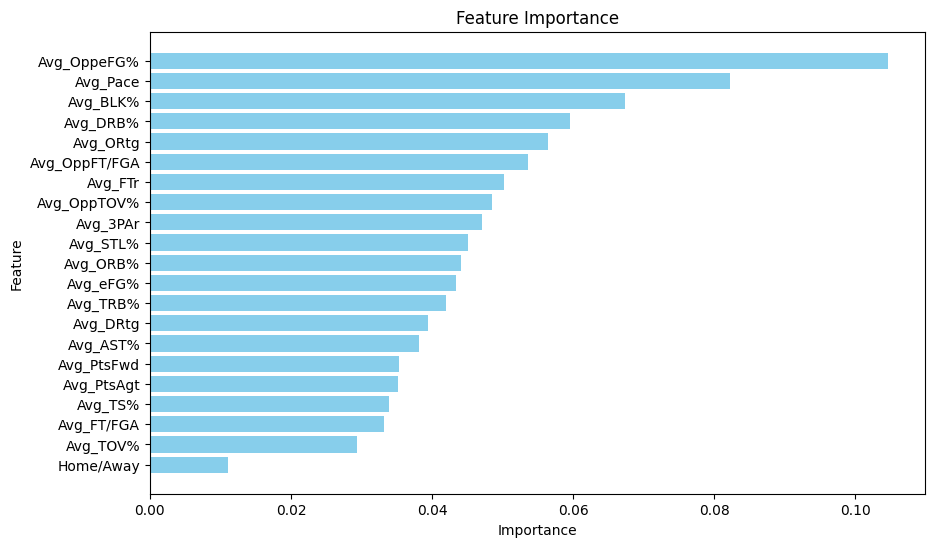

In [126]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [128]:
# Initialize the model
model = LogisticRegression(max_iter=1000)

# Perform RFE
rfe = RFE(model, n_features_to_select=10)  # Adjust the number of features to keep
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Home/Away', 'Avg_PtsFwd', 'Avg_PtsAgt', 'Avg_DRtg', 'Avg_Pace',
       'Avg_STL%', 'Avg_BLK%', 'Avg_TOV%', 'Avg_OppeFG%', 'Avg_OppFT/FGA'],
      dtype='object')
